In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.utils import shuffle
from Util import GetImageData, ErrorRate, InitWeightAndBias, InitFilter, Y2Indicator
from AnnTF import HiddenLayer

def init_filter(shape, poolsz):
    w = np.random.randn(*shape) * np.sqrt(2) / np.sqrt(np.prod(shape[:-1]) + shape[-1]*np.prod(shape[:-2] / np.prod(poolsz)))
    return w.astype(np.float32)


X.shape: (40263, 48, 48, 1)
i: 0 j: 0 nb: 1308 cost: 2.2624388 error rate: 0.887
i: 0 j: 20 nb: 1308 cost: 2.2508373 error rate: 0.786
i: 0 j: 40 nb: 1308 cost: 2.238235 error rate: 0.786
i: 0 j: 60 nb: 1308 cost: 2.2389517 error rate: 0.786
i: 0 j: 80 nb: 1308 cost: 2.238029 error rate: 0.786
i: 0 j: 100 nb: 1308 cost: 2.2350845 error rate: 0.786
i: 0 j: 120 nb: 1308 cost: 2.2288973 error rate: 0.786
i: 0 j: 140 nb: 1308 cost: 2.2286131 error rate: 0.786
i: 0 j: 160 nb: 1308 cost: 2.2303371 error rate: 0.786
i: 0 j: 180 nb: 1308 cost: 2.2266543 error rate: 0.786
i: 0 j: 200 nb: 1308 cost: 2.2209816 error rate: 0.786
i: 0 j: 220 nb: 1308 cost: 2.2156734 error rate: 0.786
i: 0 j: 240 nb: 1308 cost: 2.2119157 error rate: 0.786
i: 0 j: 260 nb: 1308 cost: 2.2084224 error rate: 0.789
i: 0 j: 280 nb: 1308 cost: 2.207375 error rate: 0.786
i: 0 j: 300 nb: 1308 cost: 2.1943047 error rate: 0.776
i: 0 j: 320 nb: 1308 cost: 2.1861439 error rate: 0.76
i: 0 j: 340 nb: 1308 cost: 2.1755943 error rate

i: 2 j: 360 nb: 1308 cost: 1.4960691 error rate: 0.474
i: 2 j: 380 nb: 1308 cost: 1.472856 error rate: 0.454
i: 2 j: 400 nb: 1308 cost: 1.4857514 error rate: 0.465
i: 2 j: 420 nb: 1308 cost: 1.528304 error rate: 0.471
i: 2 j: 440 nb: 1308 cost: 1.464537 error rate: 0.472
i: 2 j: 460 nb: 1308 cost: 1.5007615 error rate: 0.485
i: 2 j: 480 nb: 1308 cost: 1.4846832 error rate: 0.474
i: 2 j: 500 nb: 1308 cost: 1.4872758 error rate: 0.477
i: 2 j: 520 nb: 1308 cost: 1.487431 error rate: 0.473
i: 2 j: 540 nb: 1308 cost: 1.4760449 error rate: 0.47
i: 2 j: 560 nb: 1308 cost: 1.4719627 error rate: 0.454
i: 2 j: 580 nb: 1308 cost: 1.4871767 error rate: 0.469
i: 2 j: 600 nb: 1308 cost: 1.4692522 error rate: 0.459
i: 2 j: 620 nb: 1308 cost: 1.4589828 error rate: 0.444
i: 2 j: 640 nb: 1308 cost: 1.4385866 error rate: 0.44
i: 2 j: 660 nb: 1308 cost: 1.4449816 error rate: 0.449
i: 2 j: 680 nb: 1308 cost: 1.4549772 error rate: 0.456
i: 2 j: 700 nb: 1308 cost: 1.440901 error rate: 0.46
i: 2 j: 720 nb: 13

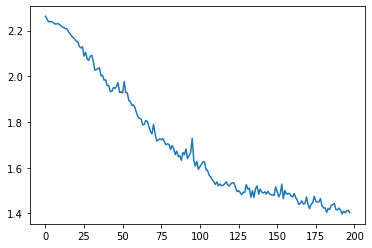

In [5]:
class ConvPoolLayer(object):
    def __init__(self, mi, mo, fw=5, fh=5, poolsz=(2, 2)):
        # mi = input feature map size
        # mo = output feature map size
        sz = (fw, fh, mi, mo)
        W0 = InitFilter(sz, poolsz)
        self.W = tf.Variable(W0)
        b0 = np.zeros(mo, dtype=np.float32)
        self.b = tf.Variable(b0)
        self.poolsz = poolsz
        self.params = [self.W, self.b]

    def forward(self, X):
        conv_out = tf.nn.conv2d(X, self.W, strides=[1, 1, 1, 1], padding='SAME')
        conv_out = tf.nn.bias_add(conv_out, self.b)
        p1, p2 = self.poolsz
        pool_out = tf.nn.max_pool(
            conv_out,
            ksize=[1, p1, p2, 1],
            strides=[1, p1, p2, 1],
            padding='SAME'
        )
        return tf.tanh(pool_out)


class CNN(object):
    def __init__(self, convPoolLayerSizes, hiddenLayerSizes):
        self.convPoolLayerSizes = convPoolLayerSizes
        self.hiddenLayerSizes = hiddenLayerSizes

    def fit(self, X, Y, lr=1e-3, mu=0.99, reg=1e-3, decay=0.99999, eps=1e-10, batch_sz=30, epochs=3, show_fig=True):
        lr = np.float32(lr)
        mu = np.float32(mu)
        reg = np.float32(reg)
        decay = np.float32(decay)
        eps = np.float32(eps)
        K = len(set(Y))

        # make a validation set
        X, Y = shuffle(X, Y)
        X = X.astype(np.float32)
        Y = Y2Indicator(Y).astype(np.float32)

        Xvalid, Yvalid = X[-1000:], Y[-1000:]
        X, Y = X[:-1000], Y[:-1000]
        Yvalid_flat = np.argmax(Yvalid, axis=1) # for calculating error rate

        # initialize convpool layers
        N, width, height, c = X.shape
        mi = c
        outw = width
        outh = height
        self.convPoolLayers = []
        for mo, fw, fh in self.convPoolLayerSizes:
            layer = ConvPoolLayer(mi, mo, fw, fh)
            self.convPoolLayers.append(layer)
            outw = outw // 2
            outh = outh // 2
            mi = mo

        # initialize mlp layers
        self.hiddenLayers = []
        M1 = self.convPoolLayerSizes[-1][0]*outw*outh # size must be same as output of last convpool layer
        count = 0
        for M2 in self.hiddenLayerSizes:
            h = HiddenLayer(M1, M2, count)
            self.hiddenLayers.append(h)
            M1 = M2
            count += 1

        # logistic regression layer
        W, b = InitWeightAndBias(M1, K)
        self.W = tf.Variable(W, 'W_logreg')
        self.b = tf.Variable(b, 'b_logreg')

        # collect params for later use
        self.params = [self.W, self.b]
        for h in self.convPoolLayers:
            self.params += h.params
        for h in self.hiddenLayers:
            self.params += h.params

        # set up tensorflow functions and variables
        tfX = tf.placeholder(tf.float32, shape=(None, width, height, c), name='X')
        tfY = tf.placeholder(tf.float32, shape=(None, K), name='Y')
        act = self.forward(tfX)

        rcost = reg*sum([tf.nn.l2_loss(p) for p in self.params])
        cost = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(
                logits=act,
                labels=tfY
            )
        ) + rcost
        prediction = self.predict(tfX)

        train_op = tf.train.RMSPropOptimizer(lr, decay=decay, momentum=mu).minimize(cost)

        n_batches = N // batch_sz
        costs = []
        init = tf.global_variables_initializer()
        with tf.Session() as session:
            session.run(init)
            for i in range(epochs):
                X, Y = shuffle(X, Y)
                for j in range(n_batches):
                    Xbatch = X[j*batch_sz:(j*batch_sz+batch_sz)]
                    Ybatch = Y[j*batch_sz:(j*batch_sz+batch_sz)]

                    session.run(train_op, feed_dict={tfX: Xbatch, tfY: Ybatch})

                    if j % 20 == 0:
                        c = session.run(cost, feed_dict={tfX: Xvalid, tfY: Yvalid})
                        costs.append(c)

                        p = session.run(prediction, feed_dict={tfX: Xvalid, tfY: Yvalid})
                        e = ErrorRate(Yvalid_flat, p)
                        print("i:", i, "j:", j, "nb:", n_batches, "cost:", c, "error rate:", e)

        if show_fig:
            plt.plot(costs)
            plt.show()

    def forward(self, X):
        Z = X
        for c in self.convPoolLayers:
            Z = c.forward(Z)
        Z_shape = Z.get_shape().as_list()
        Z = tf.reshape(Z, [-1, np.prod(Z_shape[1:])])
        for h in self.hiddenLayers:
            Z = h.forward(Z)
        return tf.matmul(Z, self.W) + self.b

    def predict(self, X):
        pY = self.forward(X)
        return tf.argmax(pY, 1)


def main():
    X, Y = GetImageData()

    # reshape X for tf: N x w x h x c
    X = X.transpose((0, 2, 3, 1))
    print("X.shape:", X.shape)

    model = CNN(
        convPoolLayerSizes =[(20, 5, 5), (20, 5, 5)],
        hiddenLayerSizes=[500, 300],
    )
    model.fit(X, Y)

if __name__ == '__main__':
    main()